In [2]:
! pip install sklearn-genetic-opt xgboost

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [3]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.applications.xception import Xception
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, \
    confusion_matrix
from sklearn.svm import SVC
from sklearn_genetic import GASearchCV
from sklearn_genetic.plots import plot_search_space
from sklearn_genetic.space import Continuous, Categorical, Integer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

2023-12-26 23:31:48.644863: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-26 23:31:49.081277: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 23:31:49.081349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 23:31:49.113550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 23:31:49.240747: I tensorflow/core/platform/cpu_feature_guar

In [4]:
# Load images and labels
path_local = "../facial_emotion_dataset/"
path_kaggle = "/kaggle/input/facial-emotion/"

general_path = path_local if os.path.exists(path_local) else path_kaggle
path_train_images = os.path.join(general_path, "train")  # Path to training images
path_test_images = os.path.join(general_path, "test")  # Path to test images

In [5]:
def limit_data(data_dir):
    a = []
    for i in os.listdir(data_dir):
        for k, j in enumerate(os.listdir(data_dir + '/' + i)):
            a.append((f'{data_dir}/{i}/{j}', i))
    return pd.DataFrame(a, columns=['filename', 'class'])

In [ ]:
# Use the function to limit the data
limited_train_data = limit_data(path_train_images)
limited_test_data = limit_data(path_test_images)

In [6]:
# Data augmentation
datagen = ImageDataGenerator(rescale=1. / 255)
train_dataset = datagen.flow_from_dataframe(dataframe=limited_train_data)
test_dataset = datagen.flow_from_dataframe(dataframe=limited_test_data)

Found 112 validated image filenames belonging to 8 classes.
Found 40 validated image filenames belonging to 8 classes.


In [7]:
train_dataset.image_shape

(256, 256, 3)

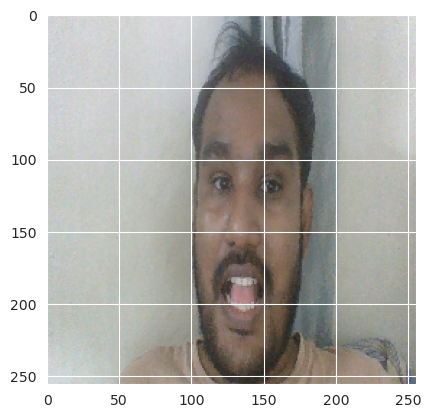

In [8]:
plt.imshow(train_dataset.next()[0][0])

# Now we will try to use exception Feature extraction architecture 

In [16]:
non_trainable_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(train_dataset.image_shape[0], train_dataset.image_shape[1], train_dataset.image_shape[2])
)

In [17]:
for layer in non_trainable_model.layers:
    layer.trainable = False

In [18]:
x = non_trainable_model.output
x = tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
flatten = tf.keras.layers.Flatten()(x)
predictions = tf.keras.layers.Dense(8, activation='softmax')(flatten)

In [19]:
#x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [20]:
model = tf.keras.Model(inputs=non_trainable_model.input, outputs=predictions)

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(train_dataset, epochs=30)

Epoch 1/30
4/4 [==============================] - 12s 3s/step - loss: 2.8978 - accuracy: 0.1429
Epoch 2/30
4/4 [==============================] - 10s 2s/step - loss: 2.0169 - accuracy: 0.2054
Epoch 3/30
4/4 [==============================] - 10s 2s/step - loss: 1.9960 - accuracy: 0.2143
Epoch 4/30
4/4 [==============================] - 10s 2s/step - loss: 1.9504 - accuracy: 0.1964
Epoch 5/30
4/4 [==============================] - 10s 2s/step - loss: 1.8508 - accuracy: 0.2946
Epoch 6/30
4/4 [==============================] - 9s 2s/step - loss: 1.7631 - accuracy: 0.3214
Epoch 7/30
4/4 [==============================] - 10s 2s/step - loss: 1.6397 - accuracy: 0.4196
Epoch 8/30
4/4 [==============================] - 10s 2s/step - loss: 1.4746 - accuracy: 0.4643
Epoch 9/30
4/4 [==============================] - 9s 2s/step - loss: 1.3895 - accuracy: 0.5000
Epoch 10/30
4/4 [==============================] - 9s 2s/step - loss: 1.2800 - accuracy: 0.6071
Epoch 11/30
4/4 [=========================

In [23]:
model2 = tf.keras.Model(inputs=non_trainable_model.input, outputs=flatten)

In [24]:
#plot_model(non_trainable_model, to_file='Xception_base_model.png', show_shapes=True)

In [25]:
train_data_flatten = model2.predict(train_dataset)
test_data_flatten = model2.predict(test_dataset)

2/2 [==============================] - 5s 3s/step


In [26]:
y_train = np.array(train_dataset.classes)
y_test = np.array(test_dataset.classes)

In [27]:
train_dataset.next()[0].shape, y_train.shape, train_data_flatten.shape

((32, 256, 256, 3), (112,), (112, 180))

In [28]:
y_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7])

In [29]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7])

# SVM

In [30]:
svm_model = SVC(kernel='poly', C=1, gamma='auto')

In [31]:
svm_model.fit(train_data_flatten, y_train)

SVC(C=1, gamma='auto', kernel='poly')

In [32]:
accuracy_svm = svm_model.score(test_data_flatten, y_test)
print("Accuracy:", accuracy_svm)

Accuracy: 0.1


In [33]:
# Define the search space for hyperparameters
search_space_svm = {
    'C': Continuous(0.1, 10),
    'gamma': Categorical(['scale', 'auto']),
    'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
    'degree': Integer(1, 6),
    'coef0': Continuous(0, 1),
    'shrinking': Categorical([True, False]),
    'probability': Categorical([True, False]),
    'tol': Continuous(1e-5, 1e-2),
}

In [34]:
# Use the genetic algorithm to search for the best hyperparameters
genetic_algo_svm = GASearchCV(
    estimator=svm_model,
    param_grid=search_space_svm,
    scoring='accuracy',
    cv=2,
    verbose=True,
    generations=40,
    n_jobs=-1
)

In [35]:
train_data_flatten.shape, y_train.shape

((112, 180), (112,))

In [36]:
genetic_algo_svm.fit(train_data_flatten, y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.144286	0.0269258  	0.205357   	0.0714286  
1  	100   	0.161786	0.0185267  	0.205357   	0.133929   
2  	100   	0.172679	0.0188653  	0.205357   	0.142857   
3  	100   	0.188214	0.0175727  	0.232143   	0.151786   
4  	100   	0.199643	0.0163429  	0.232143   	0.151786   
5  	100   	0.209464	0.0129029  	0.232143   	0.1875     
6  	100   	0.217857	0.0139469  	0.232143   	0.196429   
7  	100   	0.223571	0.0126219  	0.232143   	0.196429   
8  	100   	0.22875 	0.00925992 	0.232143   	0.196429   
9  	100   	0.23    	0.00726678 	0.232143   	0.205357   
10 	100   	0.229464	0.011044   	0.232143   	0.178571   
11 	100   	0.231429	0.005      	0.232143   	0.196429   
12 	100   	0.231786	0.0025     	0.232143   	0.214286   
13 	100   	0.229643	0.0127576  	0.232143   	0.151786   
14 	100   	0.232143	2.77556e-17	0.232143   	0.232143   
15 	100   	0.23125 	0.00625    	0.232143   	0.1875     
16 	100   	0.230357	0.0061859  	0.232143   	0.20

GASearchCV(cv=2,
           estimator=SVC(C=5.793920520543272, coef0=0.5246447499164322,
                         degree=4, gamma='auto', kernel='sigmoid',
                         probability=True, shrinking=False,
                         tol=6.638660631993536e-05),
           generations=40, n_jobs=-1,
           param_grid={'C': <sklearn_genetic.space.space.Continuous object at 0x7ff2e4192dd0>,
                       'coef0': <sklearn_genetic.space.space.Continuous object at 0x7ff2e4161f50>,
                       '...
                       'gamma': <sklearn_genetic.space.space.Categorical object at 0x7ff20f565250>,
                       'kernel': <sklearn_genetic.space.space.Categorical object at 0x7ff2d4247d90>,
                       'probability': <sklearn_genetic.space.space.Categorical object at 0x7ff20f4cc310>,
                       'shrinking': <sklearn_genetic.space.space.Categorical object at 0x7ff2e413d250>,
                       'tol': <sklearn_genetic.space.space.Continuous object at 0x7ff2e419a450>},
           return_train_score=True, scoring='accuracy')

In [37]:
best_model_svm = genetic_algo_svm.best_estimator_
best_params_svm = genetic_algo_svm.best_params_

In [38]:
best_params_svm

{'C': 5.793920520543272,
 'gamma': 'auto',
 'kernel': 'sigmoid',
 'degree': 4,
 'coef0': 0.5246447499164322,
 'shrinking': False,
 'probability': True,
 'tol': 6.638660631993536e-05}

In [39]:
accuracy_svm = best_model_svm.score(test_data_flatten, y_test)
print("Accuracy:", accuracy_svm)

Accuracy: 0.15


# XGBoost

In [40]:
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    max_depth=10,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1e-5,
    gamma=0.1,
    random_state=42
)

In [41]:
xgb_model.fit(train_data_flatten, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=8,
              num_parallel_tree=None, ...)

In [42]:
accuracy_xgb = xgb_model.score(test_data_flatten, y_test)
print("Accuracy:", accuracy_xgb)

Accuracy: 0.05


In [43]:
# Define the search space for hyperparameters
search_space_xgb = {
    'max_depth': Integer(1, 10),
    'learning_rate': Continuous(0.01, 1),
    'n_estimators': Integer(10, 100),
    'subsample': Continuous(0.1, 1),
    'colsample_bytree': Continuous(0.1, 1),
    'reg_alpha': Continuous(1e-5, 1e-2),
    'gamma': Continuous(0, 1),
}

In [44]:
# Use the genetic algorithm to search for the best hyperparameters
genetic_algo_xgb = GASearchCV(
    estimator=xgb_model,
    param_grid=search_space_xgb,
    scoring='accuracy',
    cv=10,
    verbose=True,
    generations=40,
    n_jobs=-1
)

In [45]:
genetic_algo_xgb.fit(train_data_flatten, y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.131136	0.0298328  	0.195455   	0.0795455  
1  	100   	0.151848	0.020167   	0.195455   	0.0977273  
2  	100   	0.162803	0.0167129  	0.196212   	0.115909   
3  	100   	0.169091	0.0161141  	0.203788   	0.124242   
4  	100   	0.174182	0.0134805  	0.206061   	0.123485   
5  	100   	0.182576	0.0187034  	0.240152   	0.150758   
6  	100   	0.181773	0.0216245  	0.240152   	0.139394   
7  	100   	0.187652	0.0158927  	0.240152   	0.141667   
8  	100   	0.194   	0.0147926  	0.222727   	0.159091   
9  	100   	0.198742	0.0127125  	0.222727   	0.140909   
10 	100   	0.205394	0.00977436 	0.230303   	0.17803    
11 	100   	0.210379	0.0099727  	0.230303   	0.194697   
12 	100   	0.209939	0.0147754  	0.230303   	0.160606   
13 	100   	0.214091	0.012142   	0.230303   	0.176515   
14 	100   	0.21597 	0.0112007  	0.230303   	0.186364   
15 	100   	0.214591	0.0163059  	0.230303   	0.150758   
16 	100   	0.216136	0.0162984  	0.230303   	0.15

GASearchCV(cv=10,
           estimator=XGBClassifier(base_score=None, booster=None,
                                   callbacks=None, colsample_bylevel=None,
                                   colsample_bynode=None,
                                   colsample_bytree=0.9253012137227039,
                                   device=None, early_stopping_rounds=None,
                                   enable_categorical=False, eval_metric=None,
                                   feature_types=None, gamma=0.0939275647857335,
                                   grow_policy=None, importance_type=None,
                                   interaction_constrain...
                       'learning_rate': <sklearn_genetic.space.space.Continuous object at 0x7ff22dfc8dd0>,
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x7ff2e41edd10>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x7ff22d9fec50>,
                       'reg_alpha': <sklearn_genetic.space.space.Continuous object at 0x7ff2e4175090>,
                       'subsample': <sklearn_genetic.space.space.Continuous object at 0x7ff2e4199890>},
           return_train_score=True, scoring='accuracy')

In [46]:
best_model_xgb = genetic_algo_xgb.best_estimator_
best_params_xgb = genetic_algo_xgb.best_params_

In [47]:
best_params_xgb

{'max_depth': 7,
 'learning_rate': 0.447118977728237,
 'n_estimators': 14,
 'subsample': 0.9907399136014624,
 'colsample_bytree': 0.9253012137227039,
 'reg_alpha': 0.005898077418318591,
 'gamma': 0.0939275647857335}

In [48]:
accuracy_xgb = best_model_xgb.score(test_data_flatten, y_test)
print("Accuracy:", accuracy_xgb)

Accuracy: 0.05


In [49]:
class AntColonyOptimization:
    def __init__(self, num_ants, max_iter=10, Model=XGBClassifier()):
        self.model = Model
        self.best_selected_features = None
        self.best_fitness = None
        self.final_report = None
        self.final_f1 = None
        self.final_recall = None
        self.final_precision = None
        self.final_accuracy = None
        self.final_confusion_mat = None
        self.num_ants = num_ants
        self.max_iter = max_iter

    @staticmethod
    def _initialize_pheromones(num_features):
        return np.ones(num_features)

    def _select_features(self, pheromones):
        probabilities = pheromones / np.sum(pheromones)
        selected_features = np.random.choice(len(pheromones), size=self.num_ants, p=probabilities)
        return selected_features

    def _fitness(self, selected_features, X_train, Y_train, X_test, Y_test):
        if len(selected_features) == 0:
            return 0  # Penalize if no features are selected
        self.model.fit(X_train[:, selected_features], Y_train)
        y_predict = self.model.predict(X_test[:, selected_features])
        Accuracy = accuracy_score(Y_test, y_predict)
        precision = precision_score(Y_test, y_predict, average='weighted')
        recall = recall_score(Y_test, y_predict, average='weighted')
        f1 = f1_score(Y_test, y_predict, average='weighted')
        report = classification_report(Y_test, y_predict)
        confusion_mat = confusion_matrix(Y_test, y_predict)
        return Accuracy, precision, recall, f1, report, confusion_mat

    def run(self, X_train, Y_train, X_test, Y_test):
        num_features = X_train.shape[1]
        pheromones = self._initialize_pheromones(num_features)
        self.best_fitness = 0

        for iteration in range(self.max_iter):
            # Initialize ant colony
            selected_features = self._select_features(pheromones)

            # Evaluate fitness
            fitness_value = self._fitness(selected_features, X_train, Y_train, X_test, Y_test)

            # Update pheromones based on fitness values
            pheromones[selected_features] += fitness_value[0]  # Update based on accuracy (you can choose other metrics)

            print(f"Iteration: {iteration + 1},\tBest Fitness: {self.best_fitness:.4f}")

            # Update the best solution if a better one is found
            if fitness_value[0] > self.best_fitness:  # Update based on accuracy (you can choose other metrics)
                self.best_fitness = fitness_value[0]
                self.best_selected_features = selected_features

        # print("Best Selected Features:", self.best_selected_features)
        print("\nBest Fitness (Accuracy):", self.best_fitness)

        # Use the best-selected features for prediction on the test set

        self.model.fit(X_train[:, self.best_selected_features], Y_train)
        y_predict = self.model.predict(X_test[:, self.best_selected_features])

        # Calculate metrics for the final model
        self.final_accuracy = accuracy_score(Y_test, y_predict)
        self.final_precision = precision_score(Y_test, y_predict, average='weighted')
        self.final_recall = recall_score(Y_test, y_predict, average='weighted')
        self.final_f1 = f1_score(Y_test, y_predict, average='weighted')
        self.final_report = classification_report(Y_test, y_predict)
        self.final_confusion_mat = confusion_matrix(Y_test, y_predict)

        return self.best_selected_features

    def results(self):
        # Plot the confusion matrix using Seaborn
        print('The Confusion Matrix is: ')
        plt.figure(figsize=(8, 6))
        sns.heatmap(self.final_confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test),
                    yticklabels=np.unique(y_test))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Print the classification report
        print('The Classification Report is: ')
        print(self.final_report)

        # Print the accuracy, precision, recall, and f1_score
        print(f'Accuracy: {self.final_accuracy: .4f}')
        print(f'Best Fitness: {self.best_fitness: .4f}')
        print(f'Precision: {self.final_precision: .4f}')
        print(f'Recall: {self.final_recall: .4f}')
        print(f'F1-Score: {self.final_f1: .4f}')

        # Plot the search space
        plot_search_space(self.model.search_space_)

In [50]:
aco_optimizer_xgb = AntColonyOptimization(num_ants=500, max_iter=1500, Model=xgb_model)
selected_features_aco = aco_optimizer_xgb.run(train_data_flatten, y_train, test_data_flatten, y_test)

Iteration: 1,	Best Fitness: 0.0000
Iteration: 2,	Best Fitness: 0.0500
Iteration: 3,	Best Fitness: 0.0500
Iteration: 4,	Best Fitness: 0.0500
Iteration: 5,	Best Fitness: 0.0500
Iteration: 6,	Best Fitness: 0.0500
Iteration: 7,	Best Fitness: 0.0750
Iteration: 8,	Best Fitness: 0.0750
Iteration: 9,	Best Fitness: 0.0750
Iteration: 10,	Best Fitness: 0.1000
Iteration: 11,	Best Fitness: 0.1000
Iteration: 12,	Best Fitness: 0.1000
Iteration: 13,	Best Fitness: 0.1000
Iteration: 14,	Best Fitness: 0.1000
Iteration: 15,	Best Fitness: 0.1000
Iteration: 16,	Best Fitness: 0.1000
Iteration: 17,	Best Fitness: 0.1000
Iteration: 18,	Best Fitness: 0.1000
Iteration: 19,	Best Fitness: 0.1000
Iteration: 20,	Best Fitness: 0.1000
Iteration: 21,	Best Fitness: 0.1000
Iteration: 22,	Best Fitness: 0.1000
Iteration: 23,	Best Fitness: 0.1000
Iteration: 24,	Best Fitness: 0.1000
Iteration: 25,	Best Fitness: 0.1000
Iteration: 26,	Best Fitness: 0.1000
Iteration: 27,	Best Fitness: 0.1000
Iteration: 28,	Best Fitness: 0.1000
I

In [51]:
selected_features_aco

array([ 11,  89, 142, 152,  82,   3, 135,  47, 160,  24,   4,  37, 161,
        13,  41, 134,  98,   7, 111,  22, 141, 100, 115, 157,  91,  92,
        61,  55,  26,  50,  29,  50, 112, 126, 106,  33,  32, 144,  95,
       126, 154, 140, 120,  57, 129,   3,  82, 151, 141, 147, 118, 172,
       159,  71,  19, 175,  79, 143,  13,  97, 165, 100,  33,  11,  77,
        15, 148, 174, 109, 118, 162, 147, 103, 104, 164,  92, 100, 104,
        77,  49,  55, 178, 122,  66, 157, 127, 151, 132, 106,  71,  21,
       144, 110, 120,  12, 170, 166,  11, 148,  87, 109, 153,  27,  91,
         4, 114,  79, 144,  81,  31, 162, 160,  61, 101,  16,  21,  72,
       149, 151,  45,   7, 175, 173,   7,   4,  10,   6,   7,  76,  82,
        38, 177,  10,  79, 176,  99, 122,  21, 156,  84, 168, 150, 105,
       130,  50,  42,  22, 166,  83,  54, 124,  38,  48,  58, 140, 160,
        74,  17,  80, 106,  59, 145, 104, 129, 144,   1,  41,  20,  51,
       170,  98,  81,  10,  64,  44, 111, 104, 158,  81,  33, 12

The Confusion Matrix is: 


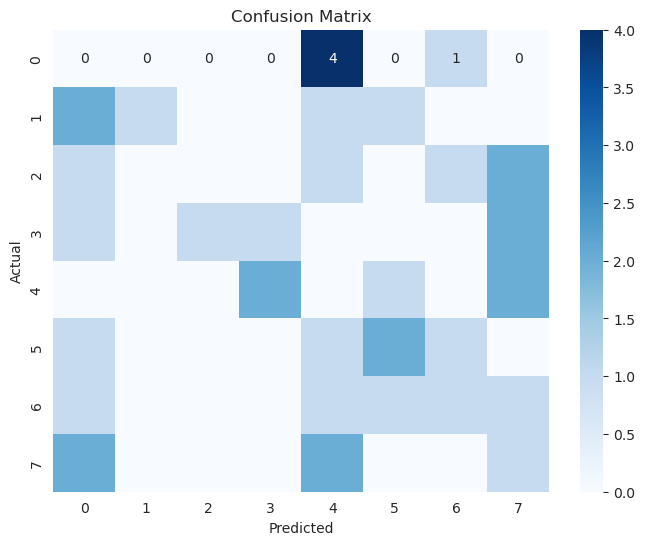

The Classification Report is: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      0.20      0.33         5
           2       0.00      0.00      0.00         5
           3       0.33      0.20      0.25         5
           4       0.00      0.00      0.00         5
           5       0.40      0.40      0.40         5
           6       0.25      0.20      0.22         5
           7       0.12      0.20      0.15         5

    accuracy                           0.15        40
   macro avg       0.26      0.15      0.17        40
weighted avg       0.26      0.15      0.17        40

Accuracy:  0.1500
Best Fitness:  0.1500
Precision:  0.2635
Recall:  0.1500
F1-Score:  0.1699


AttributeError: 'XGBClassifier' object has no attribute 'search_space_'

In [52]:
aco_optimizer_xgb.results()

In [ ]:
aco_optimizer_svm = AntColonyOptimization(num_ants=500, max_iter=1500, Model=svm_model)
selected_features_aco = aco_optimizer_svm.run(train_data_flatten, y_train, test_data_flatten, y_test)

In [ ]:
selected_features_aco

In [ ]:
aco_optimizer_svm.results()